<a href="https://colab.research.google.com/github/belanasaikiran/Team-6-Big-Data-Project/blob/main/Final_Stanford_cars_Xception_Model_for_Car_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Make & Model Detection:
This project aims to detect the make and model of a given car.  
We use Stanford Car DataSet for training the model. We have over 196 classes in total for model detection.

No. of claasses: 196

We split the data using 60-40-40 rule


Training Data:

Validation Data:

Test Data:

**Team Members**:

*   Ariannah Black
*   Sai Kiran Belana
*   Ummea Salma
*   Md Ishtyaq Mahmud

The DataSet is structured in the following manner

```
DataSet
├── data
│   ├── meta.csv
│   ├── test.csv
│   └── train.csv
└── images
    ├── cars_test
    └── cars_train
```


## Todo:
- [x] Import the DataSet.
- [x] Preprocessing
- [x] Feature Selection
- [x] Model Selection
- [x] Training the Model
- [x] Test the Model

In [1]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

# see the GPU in use
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


Tensorflow version 2.15.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9499521861434330397
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15510929408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2464715945465475379
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
xla_global_id: 416903419
]


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import warnings
import seaborn as sns
import matplotlib.pylab as plt
import PIL
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score
from keras import backend as K
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import *
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

warnings.filterwarnings('ignore')
K.image_data_format()

'channels_last'

In [26]:
BATCH_SIZE = 32
EPOCHS = 50
k_folds = 2
TTA_STEPS = 5
PATIENCE = 6
SEED = 2024
BASE_MODEL = Xception
IMAGE_SIZE = 299

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
# !unzip gdrive/MyDrive/Big\ Data\ Analytics\ Project\ \(Team\ 6\)/DataSet/DataSet.zip > /dev/null # output to null
!unzip gdrive/MyDrive/BigDataAnalyticsProject/DataSet/DataSet.zip > /dev/null # output to null

Checking if image dataset is loaded

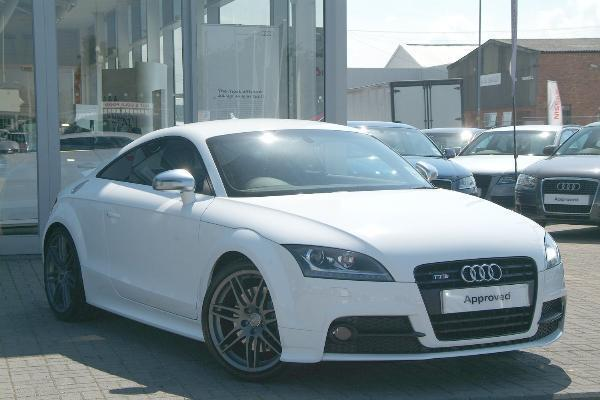

In [6]:
from PIL import Image

im = Image.open("/content/DataSet/images/cars_train/00001.jpg", "r")
im

## Load the Train & Test Datasets

In [78]:
DATA_PATH = '/content/DataSet/'
IMG_DATA_PATH = DATA_PATH + "images/"
CSV_DATA_PATH = DATA_PATH + "data/"

TRAIN_IMG_PATH = os.path.join(IMG_DATA_PATH, 'cars_train/')
TEST_IMG_PATH = os.path.join(IMG_DATA_PATH, 'cars_test/')

df_train = pd.read_csv(os.path.join(CSV_DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(CSV_DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(CSV_DATA_PATH, 'meta.csv'))

model_path = '/content/'

if not os.path.exists(model_path):
    os.mkdir(model_path)

In [8]:
def print_df(df, name):
    print(name + " Data:")
    print(df.info())
    print(df.shape)
    print("\n")

print_df(df_train, "Train")
print_df(df_test, "Test ")
print_df(df_class, "Class")

Train Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12948 entries, 0 to 12947
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12948 non-null  int64 
 1   x1          12948 non-null  int64 
 2   y1          12948 non-null  int64 
 3   x2          12948 non-null  int64 
 4   y2          12948 non-null  int64 
 5   class       12948 non-null  int64 
 6   fname       12948 non-null  object
dtypes: int64(6), object(1)
memory usage: 708.2+ KB
None
(12948, 7)


Test  Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3237 entries, 0 to 3236
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3237 non-null   int64 
 1   x1          3237 non-null   int64 
 2   y1          3237 non-null   int64 
 3   x2          3237 non-null   int64 
 4   y2          3237 non-null   int64 
 5   class       3237 non-null   int64 
 6   fname  

Fixing the fname for one of the value in CSV

In [79]:
# fix the file names here
df_train.loc[9998, 'fname'] = '09999.jpg'

# Data Preprocessing

Let's get an Average of images available per class

We should get around 66 images per class with the `stanford car dataset`

In [80]:
counter = 0 #no. of images available per class in our dataset
average = 0 #average no. of images availabe for all our classes for training

for y in range(1, 197):
  for x in df_train['class']:
    if (x == y):
      # print("x, y", x, y)
      counter = counter+1;
  average = (average + counter)/y


print("Average:", average)


Average: 66.4000624886608


### Helper Function: **Image Cropper**

> Cropping the images using bounding boxes and separating the images into their respective folders accoringly.



*   Read the dataset from CSV file
*   Iterate over each image, resize it and its bounding box in CSV
Crop the image using bounding box coordinates
*   Save the cropped image




In [10]:
def image_box_cropper(img_name, path_images, data_frame, margin=0, size=(IMAGE_SIZE,IMAGE_SIZE)):
    PATH = path_images

    img = PIL.Image.open(os.path.join(PATH, img_name))
    # once we run below command, we delete the columns as well.
    pos = data_frame.loc[data_frame["fname"] == img_name, ['x1', 'y1', 'x2', 'y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    croppedImage = img.crop((x1, y1, x2, y2)).resize(size)

    return croppedImage

In [11]:
!rm -r /content/cropped_train/
!rm -r /content/cropped_test/


rm: cannot remove '/content/cropped_train/': No such file or directory
rm: cannot remove '/content/cropped_test/': No such file or directory


In [12]:
%%time
TRAIN_CROPPED_PATH = '/content/cropped_train'
TEST_CROPPED_PATH = '/content/cropped_test'

if not os.path.isdir(TRAIN_CROPPED_PATH):
  os.mkdir(TRAIN_CROPPED_PATH)

if not os.path.isdir(TEST_CROPPED_PATH):
  os.mkdir(TEST_CROPPED_PATH)

for i, row in df_train.iterrows():
    cropped = image_box_cropper(row['fname'], TRAIN_IMG_PATH, df_train)
    cropped.save(os.path.join(TRAIN_CROPPED_PATH, row['fname']))

    if i == len(df_train) - 1:
      print("All Train Images have been cropped")

for i, row in df_test.iterrows():
    cropped = image_box_cropper(row['fname'], TEST_IMG_PATH, df_test)
    cropped.save(os.path.join(TEST_CROPPED_PATH, row['fname']))

    if i == len(df_test) - 1:
      print("All Test Images have been cropped")

All Train Images have been cropped
All Test Images have been cropped
CPU times: user 2min 31s, sys: 5.64 s, total: 2min 37s
Wall time: 2min 36s


In [86]:
df_train['class'] = df_train['class'].astype('str')
df_train = df_train[['fname', 'class']]
df_test = df_test[['fname']]

## Setting up our Helper Functions

In [14]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
def get_callback(model_name, patient):
    ES = EarlyStopping(
        monitor='val_f1_m',
        patience=patient,
        mode='max',
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'val_f1_m',
        factor = 0.5,
        patience = patient / 2,
        min_lr=0.000001,
        verbose=1,
        mode='max')
    MC = ModelCheckpoint(
        filepath=model_name,
        monitor='val_f1_m',
        verbose=1,
        save_best_only=True,
        mode='max')

    return [ES, RR, MC]


# Prepare the Data and Model for Machine Learning Algorithms
### Load the Xception Model

In [27]:
model_path = '/content/' #save model here

In [16]:
def get_model(model_name, image_size):
    base_model = model_name(weights='imagenet', input_shape=(image_size,image_size,3), include_top=False)
    #base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(2048, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(196, activation='softmax', kernel_initializer='lecun_normal'))

    optimizer = optimizers.Nadam(learning_rate=0.0003)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc', f1_m, precision_m, recall_m])

    return model

In [17]:
model = get_model(BASE_MODEL, IMAGE_SIZE)
model.summary()


83683744/83683744 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 196)               401604    
                                                                 
Total params: 25459436 (97.12 MB)
Trainable params: 25404

### Get Random Eraser:
The function generates a new function, eraser, which when applied to an image, randomly obscures part of the image with a rectangle of random size, aspect ratio, and color.


Source: https://github.com/yu4u/cutout-random-erasing

In [18]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser


## Data Augmentation (Highly Recommended):

Create an ImageDataGenerator object to perform on-the-fly data augmentation during training, which helps prevent overfitting and improve model generalization perform Data Augmentation

Since the dataset is limited, augmenting our data artificially increases the diversity of our training data.

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center= True,  # set input mean to 0 over the dataset
    #samplewise_center=True,  # set each sample mean to 0
    #featurewise_std_normalization= True,  # divide inputs by std of the dataset
    #samplewise_std_normalization=True,  # divide each input by its std
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.3,
    shear_range=0.5,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    preprocessing_function = get_random_eraser(v_l=0, v_h=255),
    )

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center= True,  # set input mean to 0 over the dataset
    #samplewise_center=True,  # set each sample mean to 0
    #featurewise_std_normalization= True,  # divide inputs by std of the dataset
    #samplewise_std_normalization=True  # divide each input by its std
    )
test_datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center= True,  # set input mean to 0 over the dataset
    #samplewise_center=True,  # set each sample mean to 0
    #featurewise_std_normalization= True,  # divide inputs by std of the dataset
    #samplewise_std_normalization=True,  # divide each input by its std
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.3,
    shear_range=0.5,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    preprocessing_function = get_random_eraser(v_l=0, v_h=255),
    )

### Plotting some augumented training images

Displaying some randomly augmented training images


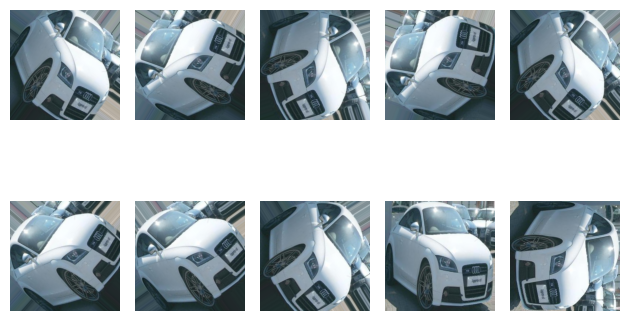

In [110]:
import matplotlib.pyplot as plt

datagen = ImageDataGenerator(rotation_range=90)

# Generate 10 augmented images from a single input image
x = np.expand_dims(plt.imread("/content/cropped_train/00001.jpg"), 0)
gen = datagen.flow(x, batch_size=1)

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(gen.next()[0].astype('uint8'))
    plt.axis('off')

plt.tight_layout()
plt.show()


### Using StratifiedKFold

> Stratified K-Fold Cross-Validation is a variation of K-Fold Cross-Validation that ensures each fold maintains the same proportion of observations for each target class as the complete dataset.

>  It ensures the training and test sets have the same proportion of the feature of interest as in the original dataset. Doing this with the target variable ensures that the cross-validation result is a close approximation of generalization error.

In [20]:
# skf = StratifiedKFold(n_splits=k_folds)
skf = KFold(n_splits=k_folds)

save model history for plotting

In [21]:
history_list = []

In [28]:
%%time
j = 1
model_names = []
for (train_index, valid_index) in skf.split(
    df_train['fname'],
    df_train['class']):


    traindf = df_train
    validdf = df_train.iloc[valid_index, :].reset_index()

    print("=========================================")
    print("====== K Fold Validation step => %d/%d =======" % (j,k_folds))
    print("=========================================")

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=traindf,
        directory=TRAIN_CROPPED_PATH,
        x_col='fname',
        y_col='class',
        target_size= (IMAGE_SIZE, IMAGE_SIZE),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=True
        )

    valid_generator = valid_datagen.flow_from_dataframe(
        dataframe=validdf,
        directory=TRAIN_CROPPED_PATH,
        x_col='fname',
        y_col='class',
        target_size= (IMAGE_SIZE, IMAGE_SIZE),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        seed=SEED,
        shuffle=True
        )

    model_name = model_path + str(j) + '_' + 'Xception-Model' + '.hdf5'
    model_names.append(model_name)

    model = get_model(BASE_MODEL, IMAGE_SIZE)

    try:
        model.load_weights(model_name)
    except:
        pass

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(traindf.index) / BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=valid_generator,
        validation_steps=len(validdf.index) / BATCH_SIZE,
        verbose=1,
        shuffle=False,
        callbacks = get_callback(model_name, PATIENCE)
        )
    history_list.append(history)

    j+=1

====== K Fold Validation step => 1/2 =======
Found 12948 validated image filenames belonging to 196 classes.
Found 6474 validated image filenames belonging to 196 classes.
Epoch 1/50
405/404 [==============================] - ETA: 0s - loss: 3.1860 - acc: 0.2800 - f1_m: 0.1906 - precision_m: 0.4898 - recall_m: 0.1273
Epoch 1: val_f1_m improved from -inf to 0.66951, saving model to /content/1_Xception-Model.hdf5
404/404 [==============================] - 368s 827ms/step - loss: 3.1860 - acc: 0.2800 - f1_m: 0.1906 - precision_m: 0.4898 - recall_m: 0.1273 - val_loss: 1.1036 - val_acc: 0.6636 - val_f1_m: 0.6695 - val_precision_m: 0.7811 - val_recall_m: 0.5885 - lr: 3.0000e-04
Epoch 2/50
405/404 [==============================] - ETA: 0s - loss: 1.0874 - acc: 0.6855 - f1_m: 0.6684 - precision_m: 0.8366 - recall_m: 0.5612
Epoch 2: val_f1_m improved from 0.66951 to 0.83822, saving model to /content/1_Xception-Model.hdf5
404/404 [==============================] - 323s 798ms/step - loss: 1.0874

In [56]:
history = history_list[0]
print(history.history.keys())

dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m', 'lr'])


In [81]:
# save history array to csv and copy the csv file to gdrive/MyDrive

import pandas as pd
import os

# Convert the history object to a pandas DataFrame
df = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
csv_file_name = 'history.csv'
df.to_csv(csv_file_name, index=False)

# Copy the CSV file to Google Drive
!cp $csv_file_name "/content/gdrive/MyDrive"


### Plotting the Training Scores

1. Accuracy
2. Loss
3. F1 Score
4. Epoch

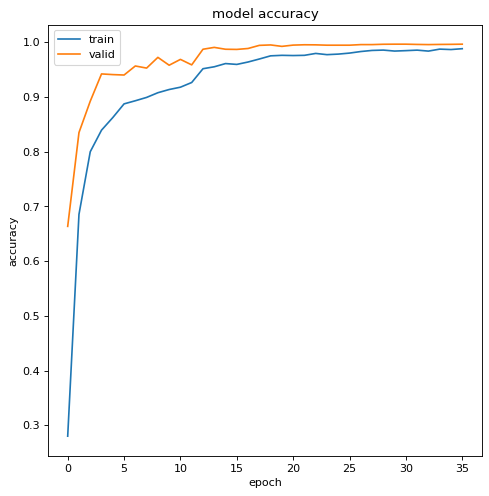

In [65]:
plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

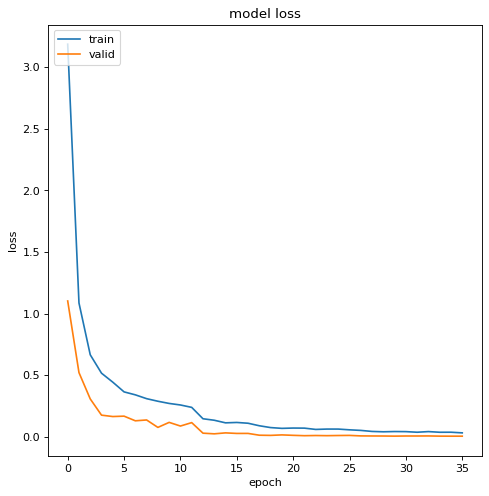

In [60]:
plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

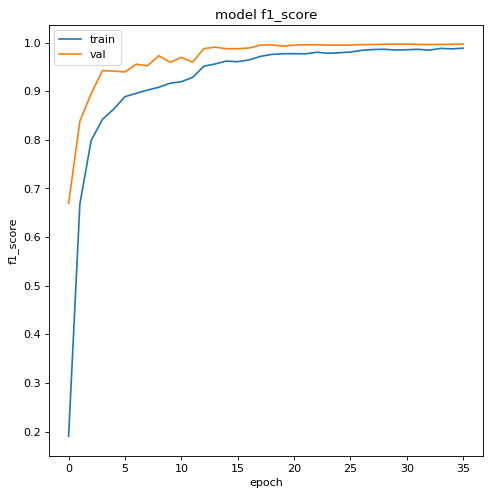

In [61]:
plt.figure(figsize=(7, 7), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

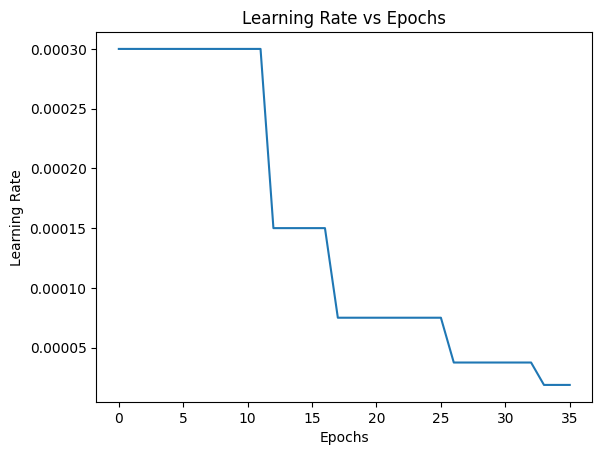

In [62]:
# get learning rate graph
def plot_learning_rate(history):
    plt.plot(history.history['lr'])
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate vs Epochs")
    plt.show()


plot_learning_rate(history)

In [37]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_CROPPED_PATH,
    x_col='fname',
    y_col=None,
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3237 validated image filenames.


### Predicting the test data images

In [38]:
prediction = []
for i, name in enumerate(model_names):
    model = get_model(BASE_MODEL, IMAGE_SIZE)
    model.load_weights(name)

    preds = []
    for j in range(TTA_STEPS):
        test_generator.reset()
        pred = model.predict_generator(
            generator=test_generator,
            steps = len(df_test)/BATCH_SIZE,
            verbose=1
        )
        preds.append(pred)
    pred_tta = np.mean(preds, axis=0)

    prediction.append(pred_tta)

y_pred = np.mean(prediction, axis=0)

101/101 [==============================] - 75s 739ms/step


In [39]:
preds_class_indices=np.argmax(y_pred, axis=1)

In [40]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
final_pred = [labels[k] for k in preds_class_indices]

In [41]:
!cp /content/DataSet/data/test.csv /content/stanford_cars_final_results.csv

# Saving all the predicted images to the CSV file to plot the test data images

In [42]:
final_result = pd.read_csv(os.path.join(DATA_PATH, '../stanford_cars_final_results.csv'))
final_result["predicted_class"] = final_pred
final_result.to_csv("stanford_cars_final_results.csv", index=False)
final_result.head(10)

Unnamed: 0   x1   y1    x2    y2  class      fname predicted_class
0           0   30   52   246   147    181  00001.jpg             181
1           1  100   19   576   203    103  00002.jpg             103
2           2   51  105   968   659    145  00003.jpg             145
3           3   67   84   581   407    187  00004.jpg             187
4           4  140  151   593   339    185  00005.jpg             185
5           5   20   77   420   301     78  00006.jpg              78
6           6  249  166  2324  1459    118  00007.jpg             118
7           7  119  215  1153   719    165  00008.jpg             165
8           8    1    7   275   183     32  00009.jpg              32
9           9   28   55   241   177     60  00010.jpg              60

### Let's Plot some images based on the predicted values by our model

> Plotting images - test data

00795.jpg
116
class_name:  Ford Fiesta Sedan 2012
original_class_name:  Ford Fiesta Sedan 2012
00247.jpg
182
class_name:  Suzuki SX4 Hatchback 2012
original_class_name:  Suzuki SX4 Hatchback 2012
02875.jpg
109
class_name:  Ford Edge SUV 2012
original_class_name:  Ford Edge SUV 2012
00364.jpg
171
class_name:  Plymouth Neon Coupe 1999
original_class_name:  Plymouth Neon Coupe 1999
00531.jpg
108
class_name:  Ford Expedition EL SUV 2009
original_class_name:  Ford Expedition EL SUV 2009
00963.jpg
53
class_name:  Chevrolet Silverado 1500 Hybrid Crew Cab 2012
original_class_name:  Chevrolet Silverado 1500 Hybrid Crew Cab 2012
02454.jpg
169
class_name:  Nissan Juke Hatchback 2012
original_class_name:  Nissan Juke Hatchback 2012
01248.jpg
65
class_name:  Chevrolet Cobalt SS 2010
original_class_name:  Chevrolet Cobalt SS 2010
01329.jpg
119
class_name:  Chevrolet Monte Carlo Coupe 2007
original_class_name:  GMC Yukon Hybrid SUV 2012
01190.jpg
143
class_name:  Jaguar XK XKR 2012
original_class_nam

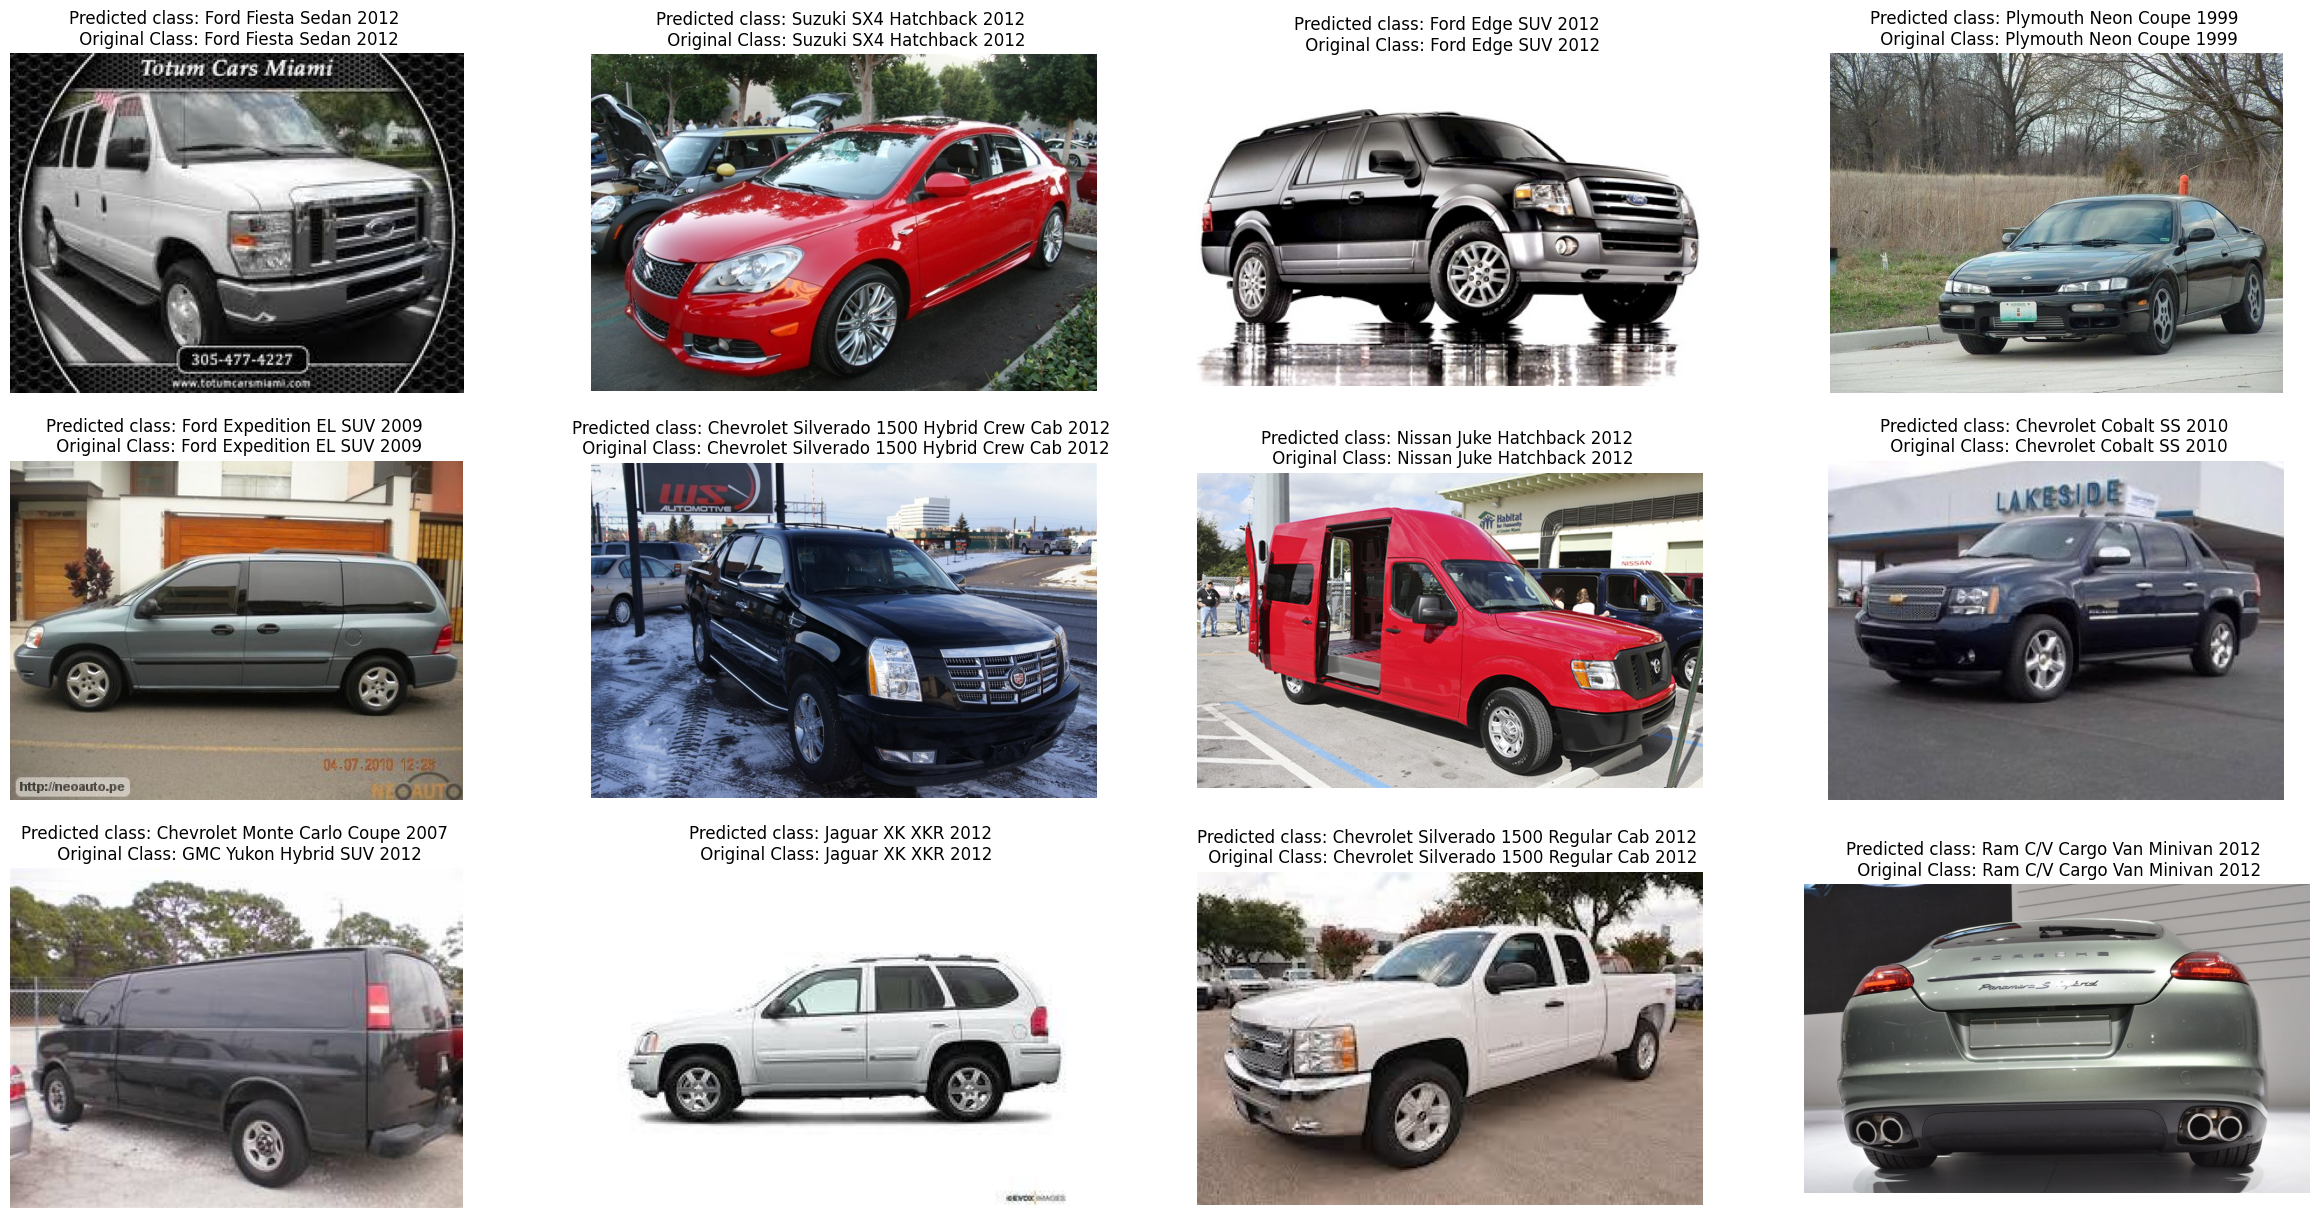

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

# Read the final_result.csv file
final_result = pd.read_csv("/content/stanford_cars_final_results.csv")

# Get a random sample of 10 images
images = final_result.sample(n=12)

# Read the class.csv file
# class_dfa = pd.read_csv("/content/class.csv")

# Create a figure with a 2x5 grid of subplots
fig, axes = plt.subplots(3, 4, figsize=(30, 15))

# Iterate through the images and display them
for idx, row in enumerate(images.iterrows()):
    # row[0] is the index, row[1] is the data
    image_file = row[1]["fname"]
    print(row[1]["fname"])
    print(row[1]["class"])

    # Read the image
    image_path = os.path.join("/content/DataSet/images/cars_test/", image_file)
    image = cv2.imread(image_path)

    # Convert color from BGR to RGB (since cv2 reads images in BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get the class name
    index = row[1]["predicted_class"]
    class_name = df_class["class_name"].iloc[index]  # Adjusted to index without +1 assuming zero-based indexing in class_dfa
    print("class_name: ", class_name)

    # original class name
    original_class_name = df_class["class_name"].iloc[row[1]["class"]]  # Adjusted to index without +1 assuming zero-based indexing in class_dfa
    print("original_class_name: ", original_class_name)

    # Display the image
    ax = axes[idx // 4, idx % 4]  # Use idx which is 0-9 for subplots
    ax.imshow(image)
    ax.set_title(f"Predicted class: {class_name} \n Original Class: {original_class_name}")
    ax.axis("off")

# Show the plot
plt.show()

In [82]:
import datetime

now = datetime.datetime.now()

time = now.strftime("%m-%d-%Y-%H:%M")
date_time = now.strftime("%Y-%m-%d:%H-%M")

print("Time:", time)
print("Date and Time:", date_time)


Time: 04-22-2024-01:39
Date and Time: 2024-04-22:01-39


### Saving the Model to Google Drive

In [75]:
current_time_str = date_time.replace(":", "at")
!mkdir /content/gdrive/MyDrive/BigDataAnalyticsProject/Models/{current_time_str}
!cp /content/*_Xception* /content/gdrive/MyDrive/BigDataAnalyticsProject/Models/{current_time_str}/


Check the number of class mismatches in test data set after predicting the results from the Xception Model

In [69]:
import pandas as pd

# Read the final_result.csv file
final_result = pd.read_csv("/content/stanford_cars_final_results.csv")

# Select rows where "class" and "predicted_class" columns are different
mismatches = final_result[final_result["class"] != final_result["predicted_class"]]

# Print the "fname" column of the mismatched rows
print(mismatches["fname"])
print(len(mismatches), " images are mismatched out of ", len(final_result), " in test dataset")


32      00033.jpg
37      00038.jpg
64      00065.jpg
69      00070.jpg
81      00082.jpg
          ...    
3158    03159.jpg
3163    03164.jpg
3214    03215.jpg
3223    03224.jpg
3230    03231.jpg
Name: fname, Length: 174, dtype: object
174  images are mismatched out of  3237  in test dataset
